In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import copy

In [2]:
# 1. ЗАГРУЗКА И ПОДГОТОВКА ИЗОБРАЖЕНИЯ

image = cv2.imread('C:\ImageProcessing\labs\Binarization_Edges\sar_3.jpg')
if image is None:
    print("Ошибка: Не удалось загрузить изображение sar_3.jpg")
    exit()

In [3]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [4]:
print(f"Размер изображения: {image_gray.shape}")

Размер изображения: (225, 225)


2. ЗАДАНИЕ 1: НАЙТИ НАИБОЛЕЕ ПРОТЯЖЕННЫЙ УЧАСТОК (ПРЕОБРАЗОВАНИЕ ХАФА)

In [5]:
# Применяем Canny для выделения границ
canny = cv2.Canny(image_gray, 50, 150, apertureSize=3)

In [6]:
# Применяем преобразование Хафа для поиска линий
lines = cv2.HoughLines(canny, 1, np.pi / 180, threshold=150)  # Подбираем порог

In [7]:
# Создаем копию для рисования линий
image_with_lines = image_rgb.copy()

In [8]:
# Находим самую длинную линию
longest_line_length = 0
longest_line = None

In [9]:
if lines is not None:
    print(f"Найдено линий: {len(lines)}")
    
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        
        # Вычисляем длину линии (расстояние между крайними точками)
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        length = math.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)
        
        # Проверяем, является ли эта линия самой длинной
        if length > longest_line_length:
            longest_line_length = length
            longest_line = (rho, theta, pt1, pt2)
        
        # Рисуем все линии (синим)
        cv2.line(image_with_lines, pt1, pt2, (0, 0, 255), 2, cv2.LINE_AA)

Найдено линий: 24


In [10]:
# Рисуем самую длинную линию (красным)
if longest_line is not None:
    rho, theta, pt1, pt2 = longest_line
    cv2.line(image_with_lines, pt1, pt2, (255, 0, 0), 4, cv2.LINE_AA)
    print(f"Самая длинная линия: длина = {longest_line_length:.2f} пикселей")

Самая длинная линия: длина = 1998.28 пикселей


In [11]:
# Визуализация результатов задания 1
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

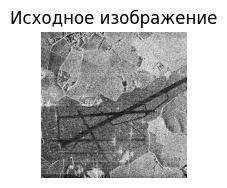

In [12]:
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Исходное изображение')
plt.axis('off')

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

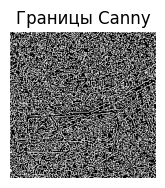

In [13]:
plt.subplot(1, 3, 2)
plt.imshow(canny, cmap='gray')
plt.title('Границы Canny')
plt.axis('off')

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

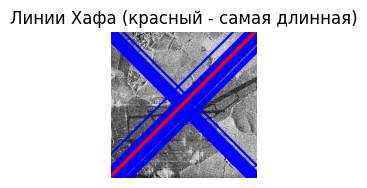

In [14]:
plt.subplot(1, 3, 3)
plt.imshow(image_with_lines)
plt.title('Линии Хафа (красный - самая длинная)')
plt.axis('off')

In [15]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

3. ЗАДАНИЕ 2: ИССЛЕДОВАНИЕ АЛГОРИТМОВ БИНАРИЗАЦИИ ДЛЯ ВЫДЕЛЕНИЯ ДОРОЖНОЙ ПОЛОСЫ

In [16]:
# 3.1 ТОЧЕЧНАЯ БИНАРИЗАЦИЯ
def test_point_binarization(image, thresholds):
    results = []
    for T in thresholds:
        bin_img = copy.deepcopy(image)
        bin_img[image < T] = 0
        bin_img[image >= T] = 255
        results.append(('Точечная', T, bin_img))
    return results

In [17]:
# 3.2 БИНАРИЗАЦИЯ ОЦУ
def test_otsu_binarization(image):
    _, th_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return [('Оцу', 'auto', th_otsu)]

In [18]:
# 3.3 АДАПТИВНАЯ БИНАРИЗАЦИЯ
def test_adaptive_binarization(image, block_sizes, constants):
    results = []
    for block_size in block_sizes:
        for C in constants:
            # Гауссовская адаптивная бинаризация
            th_gauss = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                           cv2.THRESH_BINARY, block_size, C)
            results.append(('Адапт.Гаусс', f'bs={block_size}, C={C}', th_gauss))
            
            # Средняя адаптивная бинаризация
            th_mean = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                          cv2.THRESH_BINARY, block_size, C)
            results.append(('Адапт.Средняя', f'bs={block_size}, C={C}', th_mean))
    return results

In [19]:
# Тестируем различные методы бинаризации
print("\nИССЛЕДОВАНИЕ АЛГОРИТМОВ БИНАРИЗАЦИИ:")
print("=" * 50)


ИССЛЕДОВАНИЕ АЛГОРИТМОВ БИНАРИЗАЦИИ:


In [20]:
# Параметры для тестирования
thresholds = [50, 100, 150]  # Пороги для точечной бинаризации
block_sizes = [11, 21, 31]   # Размеры блоков для адаптивной бинаризации
constants = [5, 10, 15]      # Константы для адаптивной бинаризации

In [21]:
# Применяем все методы
all_results = []
all_results.extend(test_point_binarization(image_gray, thresholds))
all_results.extend(test_otsu_binarization(image_gray))
all_results.extend(test_adaptive_binarization(image_gray, block_sizes, constants))

In [22]:
# Визуализация результатов бинаризации
num_methods = len(all_results)
rows = (num_methods + 3) // 4  # Расчет количества строк для сетки 4xN

In [23]:
plt.figure(figsize=(20, 5 * rows))

<Figure size 2000x3000 with 0 Axes>

<Figure size 2000x3000 with 0 Axes>

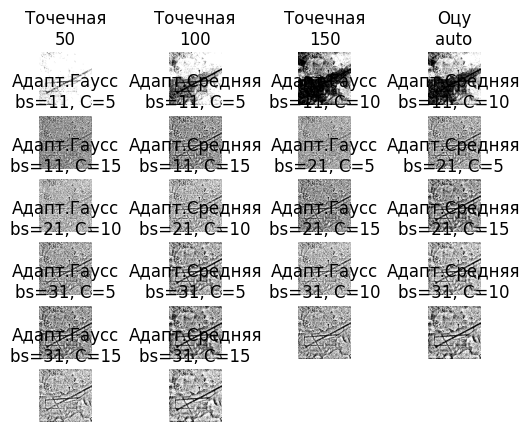

In [24]:
for i, (method_name, params, result_image) in enumerate(all_results):
    plt.subplot(rows, 4, i + 1)
    plt.imshow(result_image, cmap='gray')
    plt.title(f'{method_name}\n{params}')
    plt.axis('off')

In [25]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

4. ВЫДЕЛЕНИЕ ДОРОЖНОЙ ПОЛОСЫ С ПОМОЩЬЮ ЛУЧШЕГО МЕТОДА БИНАРИЗАЦИИ

Используем адаптивную бинаризацию Гаусса для выделения дорожной полосы
(обычно лучше работает для текстурных поверхностей типа дорог)

In [26]:
road_binary = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY, 21, 10)

In [27]:
# Улучшаем результат с помощью морфологических операций
kernel = np.ones((3, 3), np.uint8)
road_cleaned = cv2.morphologyEx(road_binary, cv2.MORPH_CLOSE, kernel)
road_cleaned = cv2.morphologyEx(road_cleaned, cv2.MORPH_OPEN, kernel)

In [28]:
# Создаем изображение с выделенной дорожной полосой
road_highlighted = image_rgb.copy()
road_highlighted[road_cleaned == 255] = [255, 0, 0]  # Выделяем красным цветом

In [29]:
# 5. ФИНАЛЬНАЯ ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

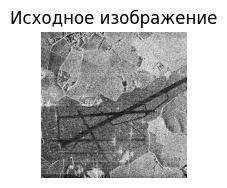

In [30]:
plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title('Исходное изображение')
plt.axis('off')

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

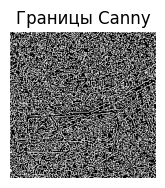

In [31]:
plt.subplot(2, 3, 2)
plt.imshow(canny, cmap='gray')
plt.title('Границы Canny')
plt.axis('off')

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

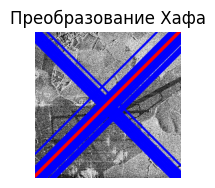

In [32]:
plt.subplot(2, 3, 3)
plt.imshow(image_with_lines)
plt.title('Преобразование Хафа')
plt.axis('off')

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

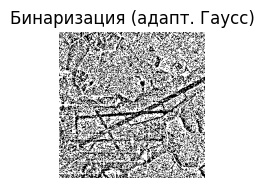

In [33]:
plt.subplot(2, 3, 4)
plt.imshow(road_binary, cmap='gray')
plt.title('Бинаризация (адапт. Гаусс)')
plt.axis('off')

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

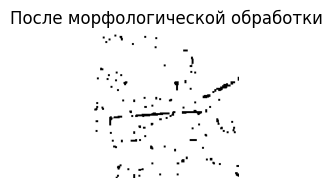

In [34]:
plt.subplot(2, 3, 5)
plt.imshow(road_cleaned, cmap='gray')
plt.title('После морфологической обработки')
plt.axis('off')

(np.float64(-0.5), np.float64(224.5), np.float64(224.5), np.float64(-0.5))

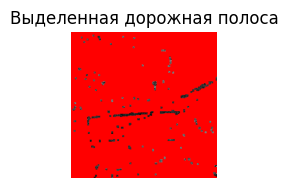

In [35]:
plt.subplot(2, 3, 6)
plt.imshow(road_highlighted)
plt.title('Выделенная дорожная полоса')
plt.axis('off')

In [36]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [37]:
# 6. ИТОГОВЫЙ АНАЛИЗ
print("\nИТОГОВЫЕ РЕЗУЛЬТАТЫ:")
print("=" * 50)
print("1. ПРЕОБРАЗОВАНИЕ ХАФА:")
if longest_line is not None:
    print(f"   - Найдена самая длинная линия: {longest_line_length:.2f} пикселей")
    print(f"   - Параметры линии: ρ={longest_line[0]:.2f}, θ={longest_line[1]:.2f}")
else:
    print("   - Линии не найдены")


ИТОГОВЫЕ РЕЗУЛЬТАТЫ:
1. ПРЕОБРАЗОВАНИЕ ХАФА:
   - Найдена самая длинная линия: 1998.28 пикселей
   - Параметры линии: ρ=156.00, θ=0.79


In [38]:
print("\n2. БИНАРИЗАЦИЯ ДОРОЖНОЙ ПОЛОСЫ:")
print("   - Использован адаптивный метод Гаусса")
print("   - Применены морфологические операции для очистки")
print("   - Дорожная полоса выделена красным цветом")


2. БИНАРИЗАЦИЯ ДОРОЖНОЙ ПОЛОСЫ:
   - Использован адаптивный метод Гаусса
   - Применены морфологические операции для очистки
   - Дорожная полоса выделена красным цветом


In [39]:
print("\n3. РЕКОМЕНДАЦИИ:")
print("   - Для улучшения результатов можно настроить параметры Canny и Хафа")
print("   - Для сложных дорожных покрытий может потребоваться комбинация методов")


3. РЕКОМЕНДАЦИИ:
   - Для улучшения результатов можно настроить параметры Canny и Хафа
   - Для сложных дорожных покрытий может потребоваться комбинация методов
